# 实验二：傅里叶描述子手写数字识别
本实验使用傅里叶描述子提取手写数字轮廓特征，并基于逻辑回归分类器实现数字识别。我们将展示描述子的计算过程、频谱特征以及在测试集上的识别效果。

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing
from skimage.measure import find_contours
from skimage.util import img_as_float


In [2]:
# 配置 matplotlib 支持中文显示
plt.rcParams["font.sans-serif"] = [
    "Sarasa Gothic SC",
    "Noto Sans CJK SC",
    "Microsoft YaHei",
    "WenQuanYi Micro Hei",
]
plt.rcParams["axes.unicode_minus"] = False


In [3]:
# 准备数据目录用于保存示例图片
data_dir = Path("..") / "data"
data_dir.mkdir(parents=True, exist_ok=True)


In [4]:
def resample_contour(contour: np.ndarray, num_points: int = 256) -> np.ndarray:
    """将轮廓重采样为固定数量的点，便于计算傅里叶描述子。"""
    if contour.shape[0] < 2:
        return np.repeat(contour[:1], num_points, axis=0)
    deltas = np.linalg.norm(np.diff(contour, axis=0), axis=1)
    cumulative = np.concatenate(([0.0], np.cumsum(deltas)))
    total_length = cumulative[-1]
    if total_length == 0:
        return np.repeat(contour[:1], num_points, axis=0)
    target = np.linspace(0, total_length, num_points, endpoint=False)
    rows = np.interp(target, cumulative, contour[:, 0])
    cols = np.interp(target, cumulative, contour[:, 1])
    return np.stack([rows, cols], axis=1)


def extract_fourier_descriptors(
    image: np.ndarray, num_descriptors: int = 32, contour_points: int = 256
) -> np.ndarray:
    """从输入图像中提取归一化后的傅里叶描述子特征。"""
    image_float = img_as_float(image)
    resized = resize(image_float, (64, 64), anti_aliasing=True)
    thresh = threshold_otsu(resized)
    binary = resized > thresh
    binary = binary_closing(binary)
    contours = find_contours(binary, 0.5)
    if not contours:
        return np.zeros(num_descriptors * 2)
    contour = max(contours, key=len)
    contour = resample_contour(contour, contour_points)
    complex_signal = contour[:, 1] + 1j * contour[:, 0]
    fft_coeffs = np.fft.fft(complex_signal)
    fft_coeffs[0] = 0
    descriptors = fft_coeffs[1 : num_descriptors + 1]
    feature = np.concatenate([descriptors.real, descriptors.imag])
    norm = np.linalg.norm(feature) + 1e-8
    return feature / norm


In [5]:
# 加载 digits 手写数字数据集
digits = load_digits()
images = digits.images
labels = digits.target
print(f"样本数: {len(images)}, 图像尺寸: {images[0].shape}")


样本数: 1797, 图像尺寸: (8, 8)


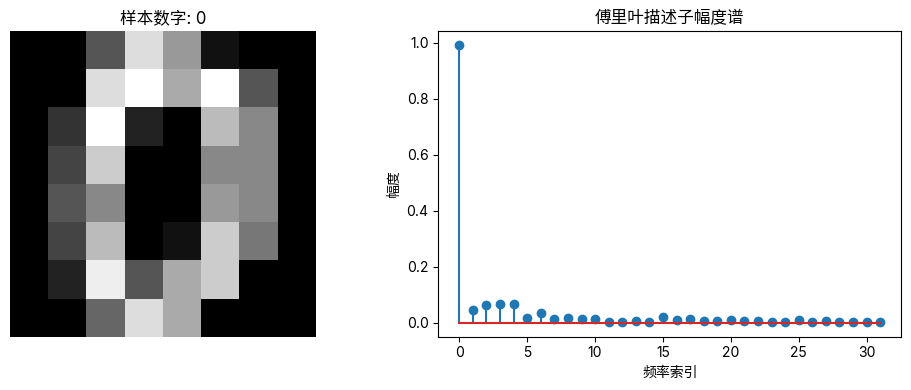

In [6]:
# 展示单个样本的轮廓与傅里叶描述子幅度
sample_idx = 0
sample_image = images[sample_idx]
descriptors = extract_fourier_descriptors(sample_image)
half = descriptors.size // 2
magnitudes = np.sqrt(descriptors[:half] ** 2 + descriptors[half:] ** 2)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(sample_image, cmap="gray")
axes[0].set_title(f"样本数字: {labels[sample_idx]}")
axes[0].axis("off")
axes[1].stem(magnitudes)
axes[1].set_title("傅里叶描述子幅度谱")
axes[1].set_xlabel("频率索引")
axes[1].set_ylabel("幅度")
plt.tight_layout()
plt.show()


In [7]:
# 批量提取傅里叶描述子特征
NUM_DESCRIPTORS = 32
features = np.array(
    [
        extract_fourier_descriptors(img, num_descriptors=NUM_DESCRIPTORS)
        for img in images
    ]
)
print(f"特征矩阵形状: {features.shape}")


特征矩阵形状: (1797, 64)


In [8]:
# 拆分数据并训练分类模型
indices = np.arange(features.shape[0])
train_idx, test_idx, y_train, y_test = train_test_split(
    indices, labels, test_size=0.25, random_state=42, stratify=labels
)
X_train = features[train_idx]
X_test = features[test_idx]
pipeline = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=1000, multi_class="multinomial")
)
pipeline.fit(X_train, y_train)
test_accuracy = pipeline.score(X_test, y_test)
print(f"测试集准确率: {test_accuracy:.4f}")


/home/weidong/Code/多媒体技术实验/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


测试集准确率: 0.6044


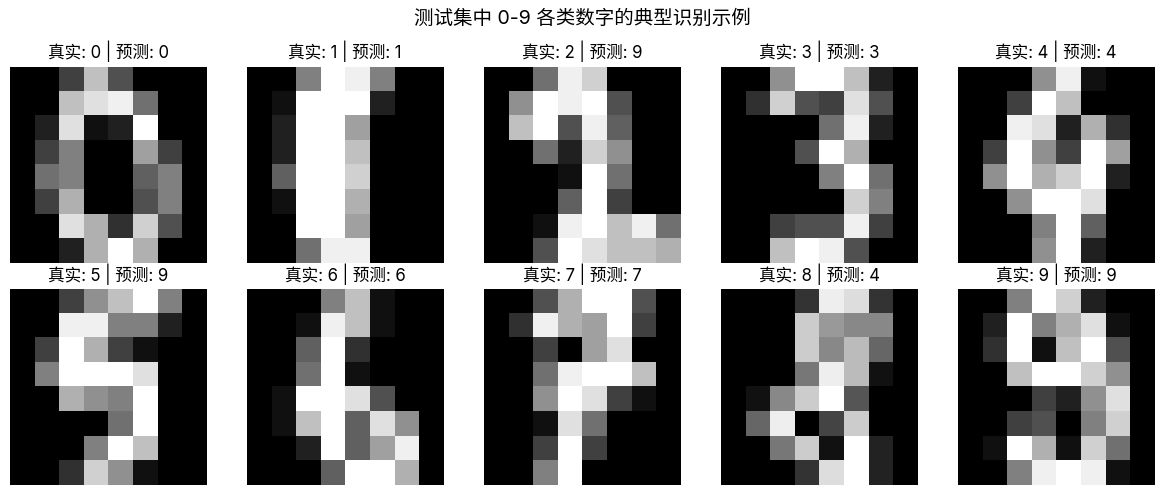

In [9]:
# 展示测试集中每个数字的典型识别结果
digit_examples = {}
for idx in test_idx:
    label = labels[idx]
    if label not in digit_examples:
        digit_examples[label] = idx
    if len(digit_examples) == 10:
        break
ordered_digits = sorted(digit_examples.keys())
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for ax, digit in zip(axes.ravel(), ordered_digits):
    sample_idx = digit_examples[digit]
    image = images[sample_idx]
    predicted = pipeline.predict([features[sample_idx]])[0]
    ax.imshow(image, cmap="gray")
    ax.set_title(f"真实: {digit} | 预测: {predicted}")
    ax.axis("off")
plt.suptitle("测试集中 0-9 各类数字的典型识别示例", fontsize=14)
plt.tight_layout()
plt.show()


In [10]:
def predict_digit_from_path(image_path: Path) -> int:
    from PIL import Image

    """从图片路径读取手写数字并输出识别结果。"""
    image = Image.open(image_path).convert("L")
    image_array = np.array(image)
    descriptors = extract_fourier_descriptors(
        image_array, num_descriptors=NUM_DESCRIPTORS
    )
    prediction = pipeline.predict([descriptors])[0]
    return int(prediction)


> 傅里叶描述子捕捉了轮廓的全局形状信息，可用于鲁棒的手写数字识别与外部图片的快速分类。